#Ubicomp Assignment #2 - 2021

###Classification of Emotional State using Multi-Modal Physiological Signals

Antonio Arbues, Alkinoos Sarioglou

----------------------------------------------------------------------

# Preparation

In [2]:
# Import libraries

!pip install pickle5
!pip3 install -U scikit-learn
import pickle5 as pickle
import numpy as np
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
from scipy.signal import welch
import matplotlib.pyplot as plt
!pip install neurokit2
!pip install neurokit
import neurokit2 as nk
import neurokit as nk1
import math
from scipy import signal
import sklearn
!pip install hrv-analysis
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, plot_poincare
import warnings
warnings.filterwarnings('ignore')

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


# 2.1 Feature Extraction and Data Analysis

##2.1.1 ECG

###A) PSD for Lead I ECG Signal of the first participant watching Clip 1 from 0-40 Hz

In [3]:
# Import data

with open("./participant_01.pkl","rb") as f:
    participant_data = pickle.load(f)

In [4]:
# Extract dataset information

ID = participant_data['ID']
FS_ECG = participant_data['FS_ECG']
FS_EEG = participant_data['FS_EEG']
FS_GSR = participant_data['FS_GSR']
FS_EMO = participant_data['FS_EMO']
recordings = participant_data['recordings']
clip_one = recordings[1]
arousal = clip_one['arousal']
valence = clip_one['valence']
ECG = clip_one['ECG']
ECG_features = clip_one['ECG_features']
EEG = clip_one['EEG']
EEG_features = clip_one['EEG_features']
GSR = clip_one['GSR']
GSR_features = clip_one['GSR_features']
EMO = clip_one['EMO']
EMO_features = clip_one['EMO_features']

In [5]:
# Extract Lead I ECG signal
print(ECG.shape)

Lead_I = ECG[:,2]-ECG[:,1]

print(Lead_I.shape)

(27997, 3)
(27997,)


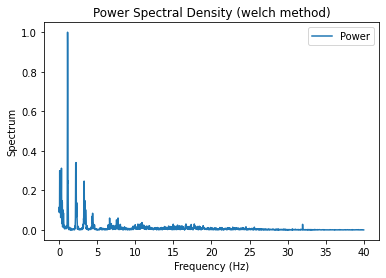

In [6]:
# Plot PSD of the Lead I ECG of the first participant watching Clip 1 from 0-40Hz

psd_welch = nk.signal_psd(Lead_I,sampling_rate=FS_ECG,method='welch',show=True,normalize=True,max_frequency=40)

###B) Filter ECG Signal

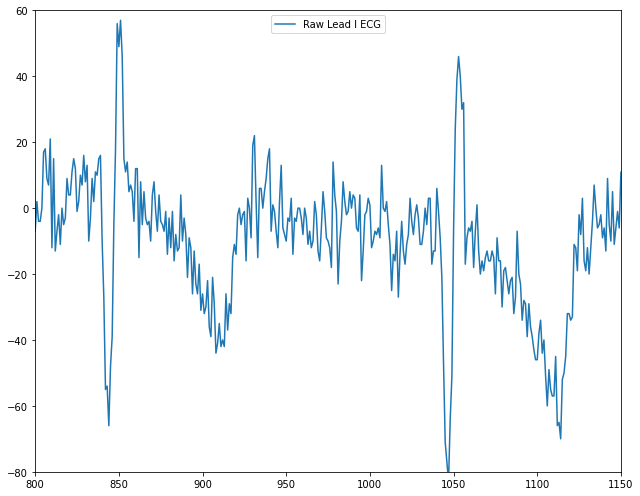

In [7]:
# Plot raw ECG signal in time-domain

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(9,7), sharex=True)

ax.plot(Lead_I, label='Raw Lead I ECG')
ax.legend(loc='upper center')

#programmatic zoom options
ax.set_xlim([800, 1150])
ax.set_ylim([-80, 60])

plt.tight_layout()
plt.show()

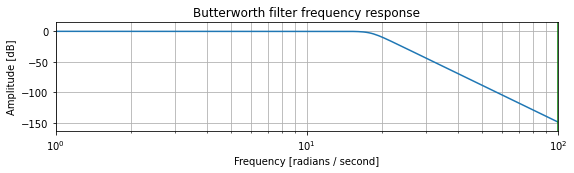

In [8]:
# Plot frequency response of the Butterworth filter
# Cut-off Frequency of 18 Hz
# Order 10

from scipy import signal

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(9,2), sharex=True)

b, a = signal.butter(10, 18, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

In [9]:
# Filter signal with cut-off of 18 Hz - Butterworth filter

filter_18 = nk.signal_filter(Lead_I, sampling_rate=FS_ECG, highcut=18, method='butterworth',order = 10)

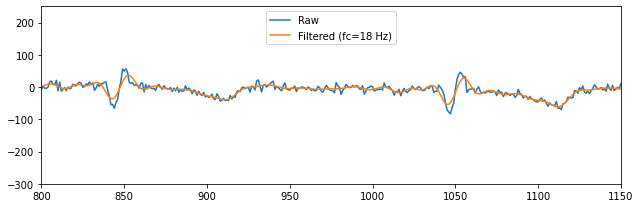

In [10]:
# Plot filtered ECG signal against raw ECG signal in time-domain

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3), sharex=True)

ax.plot(Lead_I, label='Raw')
ax.plot(filter_18, label='Filtered (fc=18 Hz)')
ax.legend(loc='upper center')

#programmatic zoom options
ax.set_xlim([800, 1150])
ax.set_ylim([-300, 250])

plt.tight_layout()
plt.show()

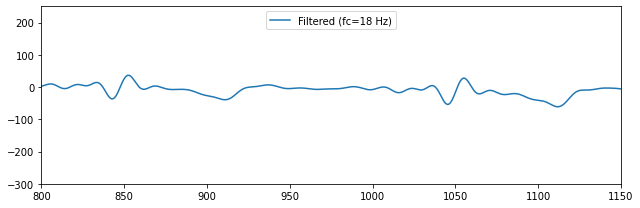

In [11]:
# Plot filtered ECG signal in time-domain

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3), sharex=True)

ax.plot(filter_18, label='Filtered (fc=18 Hz)')
ax.legend(loc='upper center')

#programmatic zoom options
ax.set_xlim([800, 1150])
ax.set_ylim([-300, 250])

plt.tight_layout()
plt.show()

###C) Percentage of ECG data with artifacts

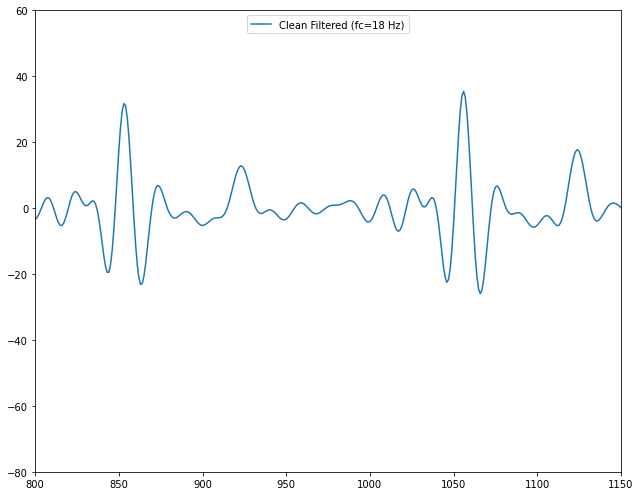

In [12]:
# Clean the filtered ECG signal
clean_signal = nk.ecg_clean(filter_18,sampling_rate=FS_ECG,method='hamilton2002')

# Plot clean ECG signal in time-domain
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(9,7), sharex=True)

ax.plot(clean_signal, label='Clean Filtered (fc=18 Hz)')
ax.legend(loc='upper center')

#programmatic zoom options
ax.set_xlim([800, 1150])
ax.set_ylim([-80, 60])

plt.tight_layout()
plt.show()

In [13]:
# Function to calculate the percentage of ECG artifacts

def calculate_percentage_of_ecg_artifacts(participant_ID):
    
    # Load data of selected participant
    with open("./participant_{0:0=2d}.pkl".format(participant_ID),"rb") as f:
        participant_data = pickle.load(f)
    
    print("Start participant {}".format(participant_ID))
    
    FS_ECG = participant_data['FS_ECG']
    
    recordings = participant_data['recordings']
    
    keys = list(recordings.keys())
    
    subj_total_samples = 0
    subj_samples_art   = 0
    
    # Loop through the clips that the participant watched
    for i in keys:

        clip = recordings[i]

        ECG = clip['ECG']

        # Extract ECG signal
        Lead_I = ECG[:,2]-ECG[:,1]

        # Filter ECG signal
        filter_18 = nk.signal_filter(Lead_I, sampling_rate=FS_ECG, highcut=18, method='butterworth',order = 10)

        # Clean filtered ECG signal
        clean_signal = nk.ecg_clean(filter_18,sampling_rate=FS_ECG,method='hamilton2002')

        # Process the clean ECG signal to extract features such as R-peaks
        signals, info = nk.ecg_process(clean_signal, sampling_rate=FS_ECG);

        # Extract RR intervals from the R-peaks
        rr_intervals_list = np.zeros((info["ECG_R_Peaks"].shape[0]-1,), dtype=np.float32)
        for i in range(1,info["ECG_R_Peaks"].shape[0]):
            rr_intervals_list[i-1] = ((info["ECG_R_Peaks"][i] - info["ECG_R_Peaks"][i-1])*(1/FS_ECG))*1000 

        # Remove outliers from the RR intervals which lie outside the range of 300 ms to 1500 ms
        rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list, low_rri=300, high_rri=1500)

        # Compute the percentage of artifacts from the location of R-peaks
        hrv = nk1.bio_ecg.ecg_hrv(info["ECG_R_Peaks"], sampling_rate=FS_ECG, hrv_features=['time'])
        percentage = hrv['n_Artifacts']
        
        print(percentage)

        total_samples = Lead_I.shape[0]

        # Calculate number of samples with artifacts
        samples_with_artifacts = int(np.round(total_samples*percentage))
        
        # Accumulate total number of ECG samples for each clip of the participant
        subj_total_samples = subj_total_samples + total_samples
        
        # Accumulate number of ECG samples with artifacts for each clip of the participant
        subj_samples_art   = subj_samples_art + samples_with_artifacts
    
    print("Finish participant {}".format(participant_ID))
    
    
    
    return subj_total_samples, subj_samples_art

In [14]:
# Loop through all participants to calculate overall percentage of ECG artifacts in the data
tot_samples      = 0
samples_with_art = 0

for i in range(1,45):
    
    current_tot_samples, current_samples_with_art = calculate_percentage_of_ecg_artifacts(i)
    
    tot_samples      = tot_samples + current_tot_samples
    samples_with_art = samples_with_art + current_samples_with_art
    
percentage = (samples_with_art/tot_samples)*100

print("The percentage of ECG data that is flagged as having artifacts is: {:.2f}%.".format(percentage))

Start participant 1
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.011494252873563218
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.018518518518518517
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(s) have been deleted.
0.0
0 outlier(

In [15]:
# Print percentage of ECG data with artifacts
print("The percentage of ECG data that is flagged as having artifacts is: {:.2f}%.".format(percentage))

The percentage of ECG data that is flagged as having artifacts is: 7.23%.


From the ECG artifacts analysis, it is obvious that the ECG signal of participant 41 watching clip 3.


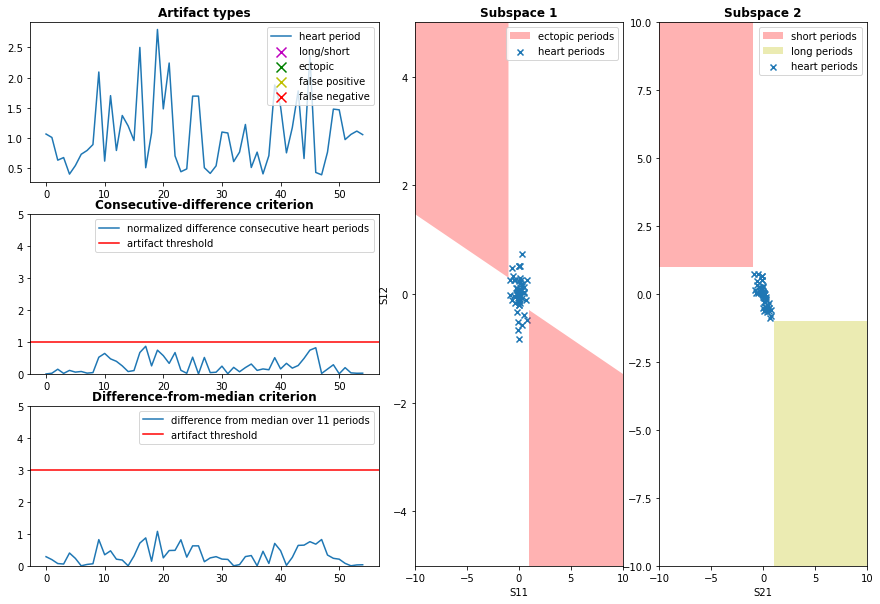

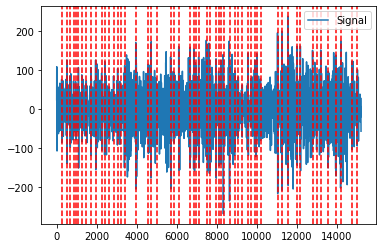

In [16]:
# Observation
print("From the ECG artifacts analysis, it is obvious that the ECG signal of participant 41 watching clip 3.")

# Plot ECG signal of participant 41 watching clip 3


with open("./participant_41.pkl","rb") as f:
        participant_data = pickle.load(f)
    
FS_ECG = participant_data['FS_ECG']
    
recordings = participant_data['recordings']
    
keys = list(recordings.keys())

#print(keys)
    
clip = recordings[3]

ECG = clip['ECG']

Lead_I = ECG[:,2]-ECG[:,1]

filter_18 = nk.signal_filter(Lead_I, sampling_rate=FS_ECG, highcut=18, method='butterworth',order = 10)

clean_signal = nk.ecg_clean(filter_18,sampling_rate=FS_ECG,method='hamilton2002')

signals, info = nk.ecg_process(clean_signal, sampling_rate=FS_ECG)

nk.ecg_plot(signals, rpeaks=info["ECG_R_Peaks"], sampling_rate=FS_ECG, show_type='artifacts')

signals, info = nk.ecg_peaks(clean_signal, sampling_rate=FS_ECG, method='neurokit')

nk.events_plot(info["ECG_R_Peaks"], clean_signal);

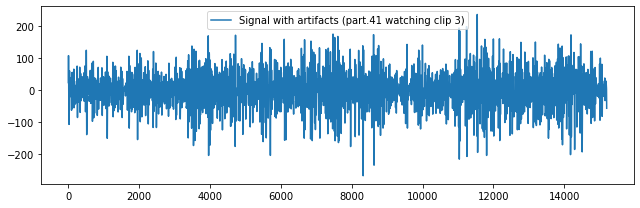

The percentage of artifacts in this ECG signal is: 69.09%.


In [17]:
# Plot ECG signal with artifacts in time-domain

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(9,3), sharex=True)

ax.plot(clean_signal, label='Signal with artifacts (part.41 watching clip 3)')
ax.legend(loc='upper center')

#programmatic zoom options
#ax.set_xlim([800, 1150])
#ax.set_ylim([-80, 60])

plt.tight_layout()
plt.show()

rr_intervals_list = np.zeros((info["ECG_R_Peaks"].shape[0]-1,), dtype=np.float32)
for i in range(1,info["ECG_R_Peaks"].shape[0]):
    rr_intervals_list[i-1] = ((info["ECG_R_Peaks"][i] - info["ECG_R_Peaks"][i-1])*(1/FS_ECG))*1000 

# rr_intervals_without_outliers = remove_outliers(rr_intervals=rr_intervals_list, low_rri=300, high_rri=1500)

hrv = nk1.bio_ecg.ecg_hrv(info["ECG_R_Peaks"], sampling_rate=FS_ECG, hrv_features=['time'])
percentage = hrv['n_Artifacts']

print("The percentage of artifacts in this ECG signal is: {:.2f}%.".format(percentage*100))

###D) Extract ECG Features for the last 50 seconds of each recording

In [18]:
# Function to calculate the required statistical measurements 

def statistical_measurements(array):

    mean = np.mean(array)
    std = statistics.stdev(array, float(mean))

    skewness = skew(array)

    kurtosis_1 = kurtosis(array)

    abovemean = sum(map(lambda x : x > mean + std, array)) / len(array)

    belowmean = sum(map(lambda x : x < mean - std, array)) / len(array)
    
    return mean, std, skewness, kurtosis_1, abovemean, belowmean

In [19]:
def calculate_ECG_features(participant_ID):
    
    with open("./participant_{0:0=2d}.pkl".format(participant_ID),"rb") as f:
        participant_data = pickle.load(f)
    
    print("Start participant {}".format(participant_ID))
    
    FS_ECG = participant_data['FS_ECG']
    
    recordings = participant_data['recordings']
    
    keys = list(recordings.keys())
    
    participant_features = np.zeros((len(keys),32), dtype=np.float32)
    
    last_seconds = 50
    
    samples_to_keep = FS_ECG*last_seconds
    
    clip_no = 0
    
    low_psd  = np.zeros((10,))
    slow_psd = np.zeros((4,))
    
    for i in keys:

        clip = recordings[i]

        ECG = clip['ECG']

        Lead_I = ECG[:,2]-ECG[:,1]
        
        kept_samples_Lead_I = Lead_I[-samples_to_keep:]

        filter_18 = nk.signal_filter(kept_samples_Lead_I, sampling_rate=FS_ECG, highcut=18, method='butterworth',order = 10)

        clean_signal = nk.ecg_clean(filter_18,sampling_rate=FS_ECG,method='hamilton2002')

        signals, info = nk.ecg_process(clean_signal, sampling_rate=FS_ECG);

        rr_intervals_list = np.zeros((info["ECG_R_Peaks"].shape[0]-1,), dtype=np.float32)
        for i in range(1,info["ECG_R_Peaks"].shape[0]):
            rr_intervals_list[i-1] = ((info["ECG_R_Peaks"][i] - info["ECG_R_Peaks"][i-1])*(1/FS_ECG))*1000
        
        # Features 1-10 - Ten Low Frequency [0-2.4] PSDs
        step = 128/(kept_samples_Lead_I.shape[0]/2)
            
        for n in range(1,11):
            
            freq = n*0.24
            
            scipy_psd_lowf = signal.periodogram(kept_samples_Lead_I, fs=FS_ECG, window='hann')
            low_psd[n-1] = scipy_psd_lowf[1][int(np.ceil(freq/step))]
            
        participant_features[clip_no][0:10] = low_psd
            
        # Features 11-14 - Four Very Slow Response [0-0.04] PSDs
        for n in range(1,5):
            
            freq = n*0.01
            
            scipy_psd_slowf = signal.periodogram(Lead_I, fs=FS_ECG, window='hann')
            slow_psd[n-1] = scipy_psd_slowf[1][int(np.ceil(freq/step))]
                
        participant_features[clip_no][10:14] = slow_psd
        
        
        # Features 15-20 - Statistical Measures of Interbeat Variability
        ibi_mean, ibi_std, ibi_skewness, ibi_kurtosis, ibi_abovemean, ibi_belowmean = statistical_measurements(rr_intervals_list)
        participant_features[clip_no][14] = ibi_mean
        participant_features[clip_no][15] = ibi_std
        participant_features[clip_no][16] = ibi_skewness
        participant_features[clip_no][17] = ibi_kurtosis
        participant_features[clip_no][18] = ibi_abovemean
        participant_features[clip_no][19] = ibi_belowmean
    
        # Features 21-26 - Statistical Measures of Heart Rate
        heart_rate = 1/(rr_intervals_list*0.001*(1/60))
        hr_mean, hr_std, hr_skewness, hr_kurtosis, hr_abovemean, hr_belowmean = statistical_measurements(heart_rate)
        participant_features[clip_no][20] = hr_mean
        participant_features[clip_no][21] = hr_std
        participant_features[clip_no][22] = hr_skewness
        participant_features[clip_no][23] = hr_kurtosis
        participant_features[clip_no][24] = hr_abovemean
        participant_features[clip_no][25] = hr_belowmean
        
        # Features 27-32 - Statistical Measures of Heart Rate Variability
        hrv = np.zeros((heart_rate.shape[0]-1,), dtype=np.float32)
        for i in range(1,heart_rate.shape[0]):
            hrv[i-1] = heart_rate[i] - heart_rate[i-1]
        hrv_mean, hrv_std, hrv_skewness, hrv_kurtosis, hrv_abovemean, hrv_belowmean = statistical_measurements(hrv)
        participant_features[clip_no][26] = hr_mean
        participant_features[clip_no][27] = hr_std
        participant_features[clip_no][28] = hr_skewness
        participant_features[clip_no][29] = hr_kurtosis
        participant_features[clip_no][30] = hr_abovemean
        participant_features[clip_no][31] = hr_belowmean        
        
                
        clip_no = clip_no + 1
        
        
    
    print("Finish participant {}".format(participant_ID))
    
    return participant_features

###E) Extract additional proposed ECG Features for the last 50 seconds of each recording

In [20]:
# Proposed Features:
# 1) Frequency analysis 5-10 Hz
# 2) Frequency analysis 10-15 Hz
# 3) RMSSD (Square Root of Mean of Sum od Successive Differences between adjacent RR intervals)
# 4) SD1SD2 (ratio between short and long term fluctuations of the RR intervals)
# 5) C1d/C1a (the contributions of heart rate decelerations and accelerations to short-term HRV)

def calculate_extra_ECG_features(participant_ID):

    # Load data
    with open("./participant_{0:0=2d}.pkl".format(participant_ID),"rb") as f:
        participant_data = pickle.load(f)
    
    print("Start participant {}".format(participant_ID))
    
    FS_ECG = participant_data['FS_ECG']
    
    recordings = participant_data['recordings']
    
    keys = list(recordings.keys())
    
    participant_features = np.zeros((len(keys),23), dtype=np.float32)
    
    # Keep samples from last 50 seconds
    last_seconds = 50
    
    samples_to_keep = FS_ECG*last_seconds
    
    clip_no = 0
    
    mid_psd  = np.zeros((10,))
    smid_psd = np.zeros((10,))
    
    for i in keys:

        # Pre-processing steps
        clip = recordings[i]

        ECG = clip['ECG']

        Lead_I = ECG[:,2]-ECG[:,1]
        
        kept_samples_Lead_I = Lead_I[-samples_to_keep:]

        filter_18 = nk.signal_filter(kept_samples_Lead_I, sampling_rate=FS_ECG, highcut=18, method='butterworth',order = 10)

        clean_signal = nk.ecg_clean(filter_18,sampling_rate=FS_ECG,method='hamilton2002')

        signals, info = nk.ecg_process(clean_signal, sampling_rate=FS_ECG);

        rr_intervals_list = np.zeros((info["ECG_R_Peaks"].shape[0]-1,), dtype=np.float32)
        for i in range(1,info["ECG_R_Peaks"].shape[0]):
            rr_intervals_list[i-1] = ((info["ECG_R_Peaks"][i] - info["ECG_R_Peaks"][i-1])*(1/FS_ECG))*1000
        
        # Extra Feature 1 - Ten Mid Frequency [5-10 Hz] PSDs, because there is a lot of information about the QRS complex in this range, which could demonstrate how fast the ventricles depolarize as a result of a change in emotion, faster depolatization for higher arousal 
        step = 128/(kept_samples_Lead_I.shape[0]/2)
            
        for n in range(1,11):
            
            freq = n*5.5
            
            scipy_psd_midf = signal.periodogram(kept_samples_Lead_I, fs=FS_ECG, window='hann')
            mid_psd[n-1] = scipy_psd_midf[1][int(np.ceil(freq/step))]
            
        participant_features[clip_no][0:10] = mid_psd
            
        # Extra Feature 2 - Ten Very Slow Response [10-15 Hz] PSDs, because there is a lot of information about the QRS complex in this range, which could demonstrate how fast the ventricles depolarize as a result of a change in emotion, faster depolatization for higher arousal 
        for n in range(1,11):
            
            freq = n*10.5
            
            scipy_psd_smidf = signal.periodogram(kept_samples_Lead_I, fs=FS_ECG, window='hann')
            smid_psd[n-1] = scipy_psd_smidf[1][int(np.ceil(freq/step))]
                
        participant_features[clip_no][10:20] = smid_psd
        
        
        # Extra Feature 3 - RMSSD (Square Root of Mean of Sum od Successive Differences between adjacent RR intervals), demonstrates differences in RR intervals over time and can show changes in trend of heart rate and hence emotion       
        hrv = nk.hrv_time(info["ECG_R_Peaks"], sampling_rate=FS_ECG)
        RMSSD = hrv["HRV_RMSSD"].values[0]
        participant_features[clip_no][20] = RMSSD
        
        # Extra Feature 4 - SD1SD2 (ratio between short and long term fluctuations of the RR intervals), shows how the RR intervals change in long term when compared to short term fluctuations, so demonstrates whether there were abrupt changes in emotion over time
        hrv_nonlinear = nk.hrv_nonlinear(info["ECG_R_Peaks"], sampling_rate=FS_ECG)
        SD1SD2 = hrv_nonlinear["HRV_SD1SD2"].values[0]
        
        # Extra Feature 5 - C1d/C1a (the contributions of heart rate decelerations and accelerations to short-term HRV), can illustrate instantaneous changes in HRV due to heart rate accelerations or decelerations which could be caused by changes in emotions
        C2d = hrv_nonlinear["HRV_C2d"].values[0]
        C2a = hrv_nonlinear["HRV_C2a"].values[0]
        participant_features[clip_no][21] = C2d
        participant_features[clip_no][22] = C2a
                
        clip_no = clip_no + 1
        
        
    
    print("Finish participant {}".format(participant_ID))
    
    return participant_features

In [23]:
# Loop through all participants and calculate all ECG features

ECG_features = []
ECG_extra_features = []

for i in range(1,45):
    
    participant_features = calculate_ECG_features(i)
    participant_extra_features = calculate_extra_ECG_features(i)
    
    ECG_features.append(participant_features)
    ECG_extra_features.append(participant_extra_features)



Start participant 1
Finish participant 1
Start participant 1
Finish participant 1
Start participant 2
Finish participant 2
Start participant 2
Finish participant 2
Start participant 3
Finish participant 3
Start participant 3
Finish participant 3
Start participant 4
Finish participant 4
Start participant 4
Finish participant 4
Start participant 5
Finish participant 5
Start participant 5
Finish participant 5
Start participant 6
Finish participant 6
Start participant 6
Finish participant 6
Start participant 7
Finish participant 7
Start participant 7
Finish participant 7
Start participant 8
Finish participant 8
Start participant 8
Finish participant 8
Start participant 9
Finish participant 9
Start participant 9
Finish participant 9
Start participant 10
Finish participant 10
Start participant 10
Finish participant 10
Start participant 11
Finish participant 11
Start participant 11
Finish participant 11
Start participant 12
Finish participant 12
Start participant 12
Finish participant 12
Star

In [24]:
# Concatenate ECG features
# Make ECG features array

ecg_feat = []
ecg_extra_feat = []

for i in range(44):
  for k in range(len(ECG_features[i])):
    ecg_feat.append(ECG_features[i][k])

for i in range(44):
  for k in range(len(ECG_extra_features[i])):
    ecg_extra_feat.append(ECG_extra_features[i][k])

ECGfeat = np.array(ecg_feat)
ECGextr = np.array(ecg_extra_feat)

ECG_features = np.concatenate((ECGfeat,ECGextr), axis = 1)
print(ECG_features.shape)





(1455, 55)


##2.1.2 EMO

###A) Compute statistical measurements for EMO features

In [26]:
# Function for plotting
def myplot(v):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
  ax.plot(v)
  plt.tight_layout()
  plt.show()

In [27]:
# Statistical measurements:
# 1- mean
# 2- standard deviation
# 3- skewness
# 4- kurtosis
# 5- % values above mean + std deviation
# 6- % values below mean - std deviation

EMO_features_list = []

# Extract useful EMO data from all participants
for idx in range(44):

  # Load data
  if idx < 9:
    with open("./participant_0" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)
  else:
    with open("./participant_" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)
  print(idx)
  
  # Loop through all clips of the participant
  for key in participantdata['recordings'].keys():

    # Re-initialise containers for next clip
    s01 = []
    s02 = []
    s03 = []
    s04 = []
    s05 = []
    s06 = []
    s07 = []
    s08 = []
    s09 = []
    s10 = []
    s11 = []
    s12 = []

    # Append data of every feature
    for L in range(len(participantdata['recordings'][key]['EMO'])):
      s01.append(participantdata['recordings'][key]['EMO'][L][1])
      s02.append(participantdata['recordings'][key]['EMO'][L][2])
      s03.append(participantdata['recordings'][key]['EMO'][L][3])
      s04.append(participantdata['recordings'][key]['EMO'][L][4])
      s05.append(participantdata['recordings'][key]['EMO'][L][5])
      s06.append(participantdata['recordings'][key]['EMO'][L][6])
      s07.append(participantdata['recordings'][key]['EMO'][L][7])
      s08.append(participantdata['recordings'][key]['EMO'][L][8])
      s09.append(participantdata['recordings'][key]['EMO'][L][9])
      s10.append(participantdata['recordings'][key]['EMO'][L][10])
      s11.append(participantdata['recordings'][key]['EMO'][L][11])
      s12.append(participantdata['recordings'][key]['EMO'][L][12])

    # Create array that includes all 12 lists
    data_statistical_EMO = [[s01], [s02], [s03], [s04], [s05], [s06], [s07], [s08], [s09], [s10], [s11], [s12]]
    clip_EMO = []

    # Extract statistics from every EMO feature
    for i in range(12):
      mean_v = scipy.mean(data_statistical_EMO[i][0])
      std_v = statistics.stdev(data_statistical_EMO[i][0])
      skewness_v = skew(data_statistical_EMO[i][0])
      kurtosis_v = kurtosis(data_statistical_EMO[i][0])
      abovemean_v = sum(map(lambda x : x > mean_v + std_v, data_statistical_EMO[i][0])) / len(data_statistical_EMO[i][0])
      belowmean_v = sum(map(lambda x : x < mean_v - std_v, data_statistical_EMO[i][0])) / len(data_statistical_EMO[i][0])
      clip_EMO += [mean_v, std_v, skewness_v, kurtosis_v, abovemean_v, belowmean_v]
    # print('len clip_emo', len(clip_EMO))

    # Append results in the overall features list
    EMO_features_list.append(clip_EMO)

# Convert final list to array
EMO_features = np.array(EMO_features_list)
print(EMO_features.shape)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
(1455, 72)


## 2.1.3 EDA

###A) PSD for EDA Signal of the second participant watching Clip 1

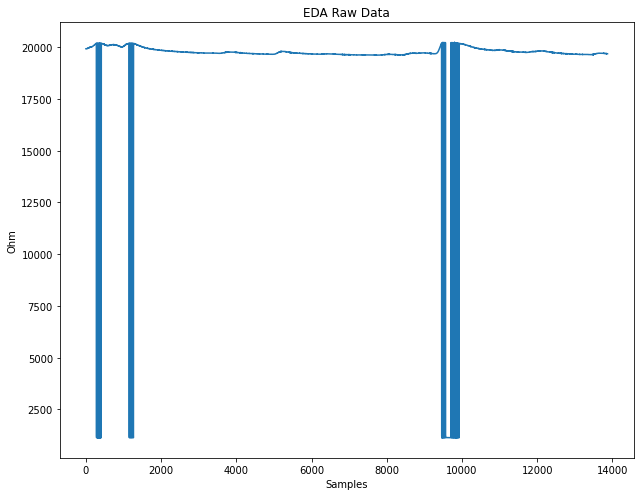

In [28]:
# Visualize example trace data of one participant

eda_v = []
with open("./participant_02.pkl", "rb") as f:
    participantdata = pickle.load(f)
for k in range(len(participantdata['recordings'][1]['GSR'])):
  eda_v.append(participantdata['recordings'][1]['GSR'][k][1])

#eda_v = filter_huge_artifacts(eda_v)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax.plot(eda_v)
ax.set_ylabel('Ohm')
ax.set_xlabel('Samples')
ax.set_title('EDA Raw Data')
plt.tight_layout()
plt.show()

In [29]:
# Function to remove the artifacts in the EDA signal

def filter_huge_artifacts(v, threshold=70):
  for i in range(len(v)):
    if i == 0:
      continue
    if abs(v[i]-v[i-1]) > threshold:
      v[i] = v[i-1]
  return v

Text(0.5, 1.0, 'PSD for EDA Signal - Participant 2 Clip 1')

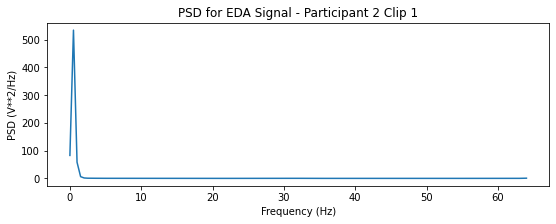

In [30]:
# Get the EDA of the second participant watching clip 1

eda_v = []
with open("./participant_02.pkl", "rb") as f:
    participantdata = pickle.load(f)
for k in range(len(participantdata['recordings'][1]['GSR'])):
  eda_v.append(participantdata['recordings'][1]['GSR'][k][1])

# Remove manually huge artifacts
eda_v = filter_huge_artifacts(eda_v)

# Extract PSD with Welch's method
f, Pxx = welch(eda_v, fs=participantdata['FS_GSR'])

# Plot PSD
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(9, 3))
ax.plot(f, Pxx)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (V**2/Hz)')
ax.set_title('PSD for EDA Signal - Participant 2 Clip 1')

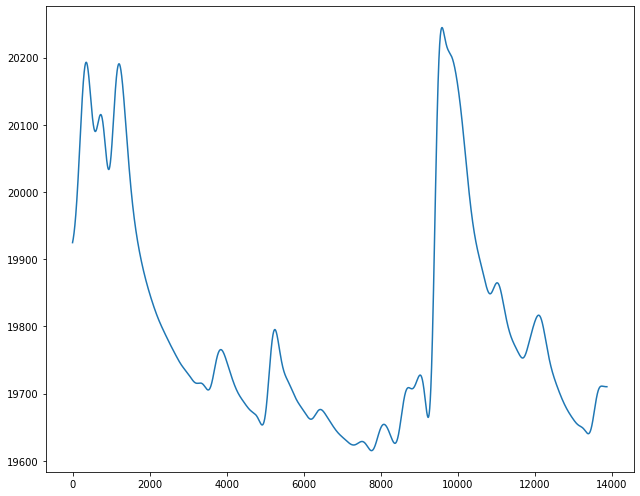

In [31]:
# Clean EDA signal (The following is only for visualization. The low-pass filter is going to be applied to the raw eda_v vector)

# Simulate EDA signal
eda_cleaned = nk.eda_clean(eda_v)
myplot(eda_cleaned)

###B) Filter EDA Signal

In [32]:
# Import required functions
from scipy.signal import butter, lfilter, freqz

# Function to design and construct
def apply_lowpass_GSR(v, order=5, f_cutoff=0.8):
  
  def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

  def butter_lowpass_filter(data, cutoff, fs, order=5):
      b, a = butter_lowpass(cutoff, fs, order=order)
      y = lfilter(b, a, data)
      return y

  # Filter requirements
  fs = participantdata['FS_GSR']       # sample rate, Hz

  # Get the filter coefficients so we can check its frequency response.
  b, a = butter_lowpass(f_cutoff, fs, order)

  # Plot the frequency response
  w, h = freqz(b, a, worN=8000)
  fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(9, 3))
  ax.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
  ax.plot(f_cutoff, 0.5*np.sqrt(2), 'ko')
  ax.axvline(f_cutoff, color='k')
  plt.xlim(0, 0.5*fs)
  plt.title("Lowpass Filter Frequency Response")
  plt.xlabel('Frequency [Hz]')
  plt.grid()

  # Filter the data, and plot both the original and filtered signals.
  y = butter_lowpass_filter(v, f_cutoff, fs, order)
  return y

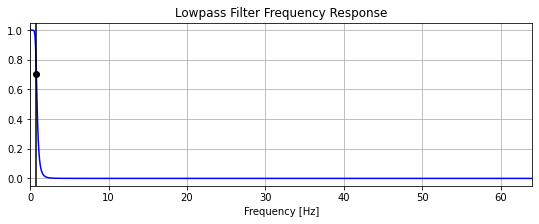

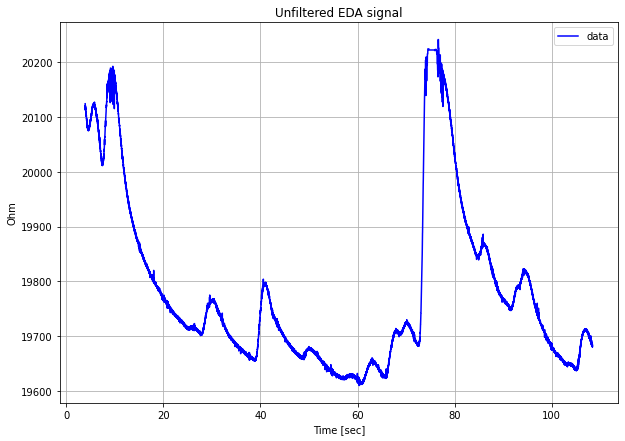

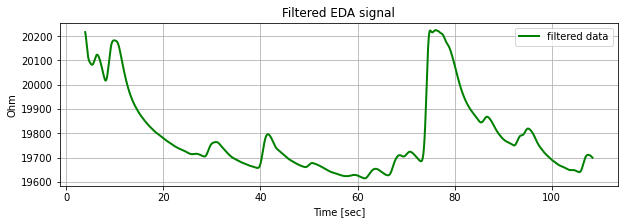

In [33]:
# The PSD shows one evident peak at relatively low frequency. Hence, it is possible to implement a low-pass filter to cut the noisy signal following the peak.
# In particular, it is necessary to cut the signal for frequencies higher than 0.8 Hz, that is about where the PSD peak ends.
# Also, different papers online report the PSD band to be less than 0.8 Hz.

# Implementation of the low-pass filter
from scipy.signal import butter, lfilter, freqz

y = apply_lowpass_GSR(eda_v)

T = len(eda_v) / participantdata['FS_GSR'] # seconds
n = len(eda_v) # total number of samples
t = np.linspace(0, T, n, endpoint=False)

# Plot unfiltered EDA signal
cut = 500
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10, 7))
ax.plot(t[cut:], eda_v[cut:], 'b-', label='data')
plt.xlabel('Time [sec]')
plt.ylabel('Ohm')
plt.title('Unfiltered EDA signal')
plt.grid()
plt.legend()

# Plot filtered EDA signal
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10, 3))
ax.plot(t[cut:], y[cut:], 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.ylabel('Ohm')
plt.title('Filtered EDA signal')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

###C) Extract EDA Features for the last 50 seconds of each recording

In [34]:
# Get local minima of a trace

def get_local_minima(a):

  local_minima = []

  for i in range(len(a)):

    if i == 0 or i == len(a)-1:
      continue

    if a[i] < a[i-1] and a[i] < a[i+1]:
      local_minima.append(a[i])

  return local_minima

In [35]:
# Extract local minima and maxima of a trace

def get_local_minmax_idx(a):

  local_min_idx = []
  local_max_idx = []

  for i in range(len(a)):

    if i == 0 or i == len(a)-1:

      continue

    if not local_min_idx and not local_max_idx:

      if a[i] < a[i-1] and a[i] < a[i+1]:

        local_min_idx.append(i)

    elif local_min_idx and not local_max_idx:

      if a[i] > a[i-1] and a[i] > a[i+1]:

        local_max_idx.append(i)

    elif a[i] < a[i-1] and a[i] < a[i+1] and local_min_idx[-1] < local_max_idx[-1]:

      local_min_idx.append(i)
      
    elif a[i] > a[i-1] and a[i] > a[i+1] and local_min_idx[-1] > local_max_idx[-1]:

      local_max_idx.append(i)
    
  # remove last element of min if there is no max
  if len(local_min_idx) == 0 or len(local_max_idx) == 0:

    return [], []

  elif local_min_idx[-1] > local_max_idx[-1]:

    local_min_idx = local_min_idx[:-1]
    
  #if len(local_min_idx) != len(local_max_idx):
  assert(len(local_min_idx) == len(local_max_idx))
  
  return local_min_idx, local_max_idx

In [36]:
# Get average rising samples

def get_avg_risingsamples(a,b):

  '''
  a --> local minima idx
  b --> local maxima idx
  '''
  v = []
  assert(len(a) == len(b))

  for i in range(len(a)):

    diff = b[i] - a[i]
    assert(diff > 0)
    v.append(diff)
    
  return scipy.mean(v)

In [37]:
# Get desired PSD
def get_desired_welch(v, fmin, fmax, howmany):

  f, Pxx = welch(v, fs=2*fmax)
  f_v = []
  Pxx_v = []
  spacing = math.floor(len(f)/howmany)

  for i in range(len(f)):

    if i == 0:
      continue
    elif i % spacing == 0:
      f_v.append(f[i])
      Pxx_v.append(Pxx[i])
      
  assert(len(f_v) == howmany)
  return f_v, Pxx_v

In [38]:
# Import required function
from numpy import diff

# Feature computation for the last 50 seconds of each recording

# Create a container for all the 15 required features
EDA_features_list = []
f01 = []
f02 = []
f03 = []
f04 = []
f05 = []
f06 = []
f07 = []
f08 = []
f09 = []
f10 = []
f11 = []
f12 = []
f13 = []
f14 = []
f15 = []

# Temporary container for each of the recordings (last 50 secs)
tmp_recordings = []

# Iterate through recordings and copy last 50 secs into tmp
for idx in range(44):

  if idx < 9:

    with open("./participant_0" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  else:

    with open("./participant_" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  # Compute number of samples correspondent to 50 secs
  n_EDA = participantdata['FS_GSR'] * 50
  for idx_rec in participantdata['recordings'].keys():

    for k in range(len(participantdata['recordings'][idx_rec]['GSR'])):

      tmp_recordings.append(participantdata['recordings'][idx_rec]['GSR'][k][1].tolist())

    tmp_recordings = tmp_recordings[-n_EDA:]
    
    # Clean data with neurokit library
    tmp_recordings = nk.eda_clean(tmp_recordings)

    assert(n_EDA == len(tmp_recordings))
    f01 = scipy.mean(tmp_recordings)

    # compute first derivative

    tmp_dx = 1 / participantdata['FS_GSR']
    tmp_first_derivative = np.diff(tmp_recordings) / tmp_dx
    f02 = scipy.mean(tmp_first_derivative)
    f03 = scipy.mean(abs(tmp_first_derivative))

    # isolate negative values of first derivative

    tmp_first_derivative_neg = []
    for el in tmp_first_derivative:

      if el < 0:

        tmp_first_derivative_neg.append(el)

    f04 = scipy.mean(tmp_first_derivative_neg)
    f05 = len(tmp_first_derivative_neg) / len(tmp_first_derivative)
    f06 = statistics.stdev(tmp_recordings)

    # get local minima

    f14 = len(get_local_minima(tmp_recordings)) #OBS this is restistance --> 14
    min_idx_EDA, max_idx_EDA = get_local_minmax_idx(tmp_recordings)
    f08 = get_avg_risingsamples(min_idx_EDA, max_idx_EDA) / participantdata['FS_GSR']
    f, P = get_desired_welch(tmp_recordings, 0., 0.4, 4)
    f09 = P

    # get conductance

    tmp_conductance = np.reciprocal(tmp_recordings).tolist()
    f10 = statistics.stdev(tmp_conductance)

    # compute first derivative of conductance

    tmp_first_derivative_cond = np.diff(tmp_conductance) / tmp_dx
    f11 = scipy.mean(tmp_first_derivative_cond)
    f12 = scipy.mean(abs(tmp_first_derivative_cond))

    # compute second derivative of conductance

    tmp_second_derivative_cond = np.diff(tmp_first_derivative_cond) / tmp_dx
    f13 = scipy.mean(abs(tmp_second_derivative_cond))
    f07 = len(get_local_minima(tmp_conductance))  #OBS this is conductance --> 07
    f, P = get_desired_welch(tmp_recordings, 0., 2.4, 10)
    f15 = P

    # empty out tmp

    tmp_recordings = []
    tmp_first_derivative_neg = []
    
    # put everything in one list

    clip_EDA = [f01, f02, f03, f04, f05, f06, f07, f08] + f09 + [f10, f11, f12, f13, f14] + f15
    EDA_features_list.append(clip_EDA)

EDA_features = np.array(EDA_features_list)
print(EDA_features.shape)

(1455, 27)


###D) Extract additional proposed EDA features for the last 50 seconds of each recording

In [39]:
# Function to get non-zero values

def get_non_zero(v):

  v1 = []
  for i in range(len(v)):

    if v[i] > 0.0:

      v1.append(v[i])

  if not v1:

    v1 = [None]

  return v1

In [40]:
# 5 additional features for emotion recognition

import neurokit2 as nk

EDA_extra_features_list = []
f01 = []
f02 = []
f03 = []
f04 = []
f05 = []

# Iterate through recordings and copy last 50 secs into tmp
tmp_recordings = []
for idx in range(44):

  if idx < 9:
    with open("./participant_0" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  else:
    with open("./participant_" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  # Compute number of samples correspondent to 50 secs
  n_EDA = participantdata['FS_GSR'] * 50
  for idx_rec in participantdata['recordings'].keys():
    for k in range(len(participantdata['recordings'][idx_rec]['GSR'])):
      tmp_recordings.append(participantdata['recordings'][idx_rec]['GSR'][k][1].tolist())
    tmp_recordings = tmp_recordings[-n_EDA:]
    
    # Clean data with neurokit library
    tmp_recordings = nk.eda_clean(tmp_recordings)
    signals, info = nk.eda_process(tmp_recordings, sampling_rate=participantdata['FS_GSR'])

    # 1 - Mean of tonic component of the signal
    f01 = scipy.mean(signals['EDA_Tonic'])

    # 2 - Mean of phasic component of the signal
    f02 = scipy.mean(signals['EDA_Phasic'])

    # 3 - Mean of SCR amplitude of the signal including the Tonic component
    f03 = scipy.mean(get_non_zero(list(signals['SCR_Height'])))

    # 4 - Maximum of SCR amplitude of the signal including the Tonic component
    f04 = max(get_non_zero(list(signals['SCR_Height'])))

    # 5 - Minimum of SCR amplitude of the signal including the Tonic component
    f05 = min(get_non_zero(list(signals['SCR_Height'])))
    tmp_recordings = []

    # Put everything in one list
    clip_EDA = [f01, f02, f03, f04, f05]
    EDA_extra_features_list.append(clip_EDA)

EDA_extra_features = np.array(EDA_extra_features_list)
print(EDA_extra_features.shape)


(1455, 5)


In [41]:
# Print example of the extra features

print(EDA_extra_features)

[[ 3.62291183e+04 -4.80667752e-01  3.14736332e+01  6.14060638e+01
   8.35542550e+00]
 [ 1.81459709e+04 -1.44679949e-01  8.28440875e+01  1.01311761e+02
   4.62477051e+01]
 [ 1.82257071e+04 -8.08388009e-01  4.83103968e+01  1.00226773e+02
   1.24302054e+01]
 ...
 [ 5.08240371e+04 -7.44322146e-02  1.88534025e+00  2.50028913e+00
   4.15757466e-01]
 [ 5.06760663e+04  1.91174852e-01  4.03832712e+00  7.41121090e+00
   6.89678708e-01]
 [ 5.04039271e+04 -1.78155879e-02  2.93906238e+02  3.45620730e+02
   2.42191746e+02]]


## 2.1.4 Valence and Arousal

###A) Pearson Correlation Coefficient between valence and arousal

In [42]:
# Function to extract arousal and valence values from the selected participant file

def extract_arousal_valence(participant_ID):

    with open("./participant_{0:0=2d}.pkl".format(participant_ID),"rb") as f:
        participant_data = pickle.load(f)
    
    print("Start participant {}".format(participant_ID))
    
    recordings = participant_data['recordings']
    
    keys = list(recordings.keys())
    
    one_arousal = []
    one_valence = []
    
    total_arousal = []
    total_valence = []
    
    clip_no = 0
    
    for i in keys:
        
        clip = recordings[i]
        arousal = clip['arousal']
        valence = clip['valence']
        
        one_arousal.append(arousal)
        one_valence.append(valence)
        
    
    return one_arousal, one_valence

In [43]:
# Loop through all participants to extract arousal and valence

total_arousal = []
total_valence = []

for i in range(1,45):
    
    part_arousal, part_valence = extract_arousal_valence(i)
    total_arousal.append(part_arousal)
    total_valence.append(part_valence)
    

Start participant 1
Start participant 2
Start participant 3
Start participant 4
Start participant 5
Start participant 6
Start participant 7
Start participant 8
Start participant 9
Start participant 10
Start participant 11
Start participant 12
Start participant 13
Start participant 14
Start participant 15
Start participant 16
Start participant 17
Start participant 18
Start participant 19
Start participant 20
Start participant 21
Start participant 22
Start participant 23
Start participant 24
Start participant 25
Start participant 26
Start participant 27
Start participant 28
Start participant 29
Start participant 30
Start participant 31
Start participant 32
Start participant 33
Start participant 34
Start participant 35
Start participant 36
Start participant 37
Start participant 38
Start participant 39
Start participant 40
Start participant 41
Start participant 42
Start participant 43
Start participant 44


In [44]:
# Extract all arousal values

arr_arousal = np.zeros((1455,),dtype=int)
n=0
for i in range(len(total_arousal)):
    for k in total_arousal[i]:
        arr_arousal[n] = k
        n = n+1

In [45]:
# Extract all valence values

arr_valence = np.zeros((1455,),dtype=int)
n=0
for i in range(len(total_valence)):
    for k in total_valence[i]:
        arr_valence[n] = k
        n = n+1

In [46]:
# Print examples of valence and arousal arrays

print(arr_arousal)
print(arr_valence)

[4 2 5 ... 4 3 4]
[ 1 -1  1 ... -3 -1 -2]


In [47]:
# Make an array with the valence and arousal values for every clip

input_x = np.zeros((2,1455))
input_x[0] = arr_arousal
input_x[1] = arr_valence
print(input_x.shape)

(2, 1455)


In [48]:
# Calculate Pearson Correlation Coefficient between valence and arousal

R_corr_coeff = np.corrcoef(input_x)
print(R_corr_coeff.shape)
print(R_corr_coeff)

print("The Pearson Correlation Coefficient between valence and arousal is: {}.".format(R_corr_coeff[0][1]))
print("The value of the Pearson Correlation Coefficient is very close to 0 and very slightly negative, therefore it means that there is no significant correlation between arousal and valence. As a result, the intensity of an emotion (arousal) is not dependent on whether the emotion is positive or negative (valence), because both negative and positive emotions can be intense or less intense.")

(2, 2)
[[ 1.         -0.01767726]
 [-0.01767726  1.        ]]
The Pearson Correlation Coefficient between valence and arousal is: -0.01767726071718607.
The value of the Pearson Correlation Coefficient is very close to 0 and very slightly negative, therefore it means that there is no significant correlation between arousal and valence. As a result, the intensity of an emotion (arousal) is not dependent on whether the emotion is positive or negative (valence), because both negative and positive emotions can be intense or less intense.


###B) Split arousal and valence levels into two classes

In [49]:
# Split arousal levels into two classes

print(arr_arousal)
low_arousal  = []
high_arousal = []

for i in arr_arousal:
    if (i<4):
        low_arousal.append(i)
    else:
        high_arousal.append(i)
        
print(len(low_arousal))
print(len(high_arousal))

print("The distribution of low arousal is {} and the distribution of high arousal is {}.".format(len(low_arousal), len(high_arousal)))

print("That means that most of the clips created high intensity of emotions in the participants.")
        

[4 2 5 ... 4 3 4]
499
956
The distribution of low arousal is 499 and the distribution of high arousal is 956.
That means that most of the clips created high intensity of emotions in the participants.


In [50]:
# Split valence levels into two classes

print(arr_valence)
low_valence  = []
high_valence = []

for i in arr_valence:
    if (i<1):
        low_valence.append(i)
    else:
        high_valence.append(i)
        
print(len(low_valence))
print(len(high_valence))

print("The distribution of low valence is {} and the distribution of high valence is {}.".format(len(low_valence), len(high_valence)))

print("That means that a small majority of the clips created negative emotions in the participants.")

[ 1 -1  1 ... -3 -1 -2]
784
671
The distribution of low valence is 784 and the distribution of high valence is 671.
That means that a small majority of the clips created negative emotions in the participants.


In [51]:
# Split arousal-valence levels into four classes

low_arousal_low_valence   = []
low_arousal_high_valence  = []
high_arousal_low_valence  = []
high_arousal_high_valence = []

for i in range(len(arr_valence)):
    if (arr_valence[i]<1 and arr_arousal[i]<4):
        low_arousal_low_valence.append((arr_arousal[i],arr_valence[i]))
    elif (arr_valence[i]>=1 and arr_arousal[i]<4):
        low_arousal_high_valence.append((arr_arousal[i],arr_valence[i]))
    elif (arr_valence[i]<1 and arr_arousal[i]>=4):
        high_arousal_low_valence.append((arr_arousal[i],arr_valence[i]))
    elif (arr_valence[i]>=1 and arr_arousal[i]>=4):
        high_arousal_high_valence.append((arr_arousal[i],arr_valence[i]))
        
print(len(low_arousal_low_valence))
print(len(low_arousal_high_valence))
print(len(high_arousal_low_valence))
print(len(high_arousal_high_valence))

print("The distribution of low arousal and low valence is {}.".format(len(low_arousal_low_valence)))
print("The distribution of low arousal and high valence is {}.".format(len(low_arousal_high_valence)))
print("The distribution of high arousal and low valence is {}.".format(len(high_arousal_low_valence)))
print("The distribution of high arousal and high valence is {}.".format(len(high_arousal_high_valence)))

print("That means that most clips created high intensity of positive emotions in the participants and only few participants had low-intensity positive emotions while watching some of the clips. Regarding negative emotions, most participants had high intensity of negative emotions rather than low-intensity ones while watching the clips.")
        

311
188
473
483
The distribution of low arousal and low valence is 311.
The distribution of low arousal and high valence is 188.
The distribution of high arousal and low valence is 473.
The distribution of high arousal and high valence is 483.
That means that most clips created high intensity of positive emotions in the participants and only few participants had low-intensity positive emotions while watching some of the clips. Regarding negative emotions, most participants had high intensity of negative emotions rather than low-intensity ones while watching the clips.


In [52]:
# Training labels

# Labels in the form of:
# 1 - low arousal, low valence
# 2 - low arousal, high valence
# 3 - high arousal, low valence
# 4 - high arousal, high valence

Arousal_Valence = np.zeros((1455,),dtype=int)

    
for i in range(len(arr_valence)):
    if (arr_valence[i]<1 and arr_arousal[i]<4):
        Arousal_Valence[i] = 1
    elif (arr_valence[i]>=1 and arr_arousal[i]<4):
        Arousal_Valence[i] = 2
    elif (arr_valence[i]<1 and arr_arousal[i]>=4):
        Arousal_Valence[i] = 3
    elif (arr_valence[i]>=1 and arr_arousal[i]>=4):
        Arousal_Valence[i] = 4
            

#2.2 Classification

###A) Report obtained accuracy, precision, recall and F1-score

####1) Leave-one-clip-out-validation scheme

In [53]:
# Function to accumulate element values of a vector

import copy

def sum_previous_ones(v):
  a = copy.deepcopy(v)
  for i in range(len(a)):
    if i == 0:
      continue
    a[i] += a[i-1]

  return a

In [83]:
# Extract the provided EEG features script

EEG_features_list = []

for idx in range(44):

  if idx < 9:
    with open("./participant_0" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  else:
    with open("./participant_" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  for i in participantdata['recordings'].keys():
    EEG_features_list.append(participantdata['recordings'][i]['ECG_features'])

EEG_features = np.array(EEG_features_list)
print(EEG_features.shape)

  

(1455, 88)


In [84]:
# Check features shapes

print(ECG_features.shape)
print(Arousal_Valence.shape)
print(EDA_features.shape)
print(EDA_extra_features.shape)
print(EEG_features.shape)
print(EMO_features.shape)

(1455, 55)
(1455,)
(1455, 27)
(1455, 5)
(1455, 88)
(1455, 72)


In [85]:
# Group data together before proceeding with classification

features = np.concatenate((ECG_features, EDA_features, EDA_extra_features, EEG_features, EMO_features), axis=1)
print(features.shape)

(1455, 247)


In [62]:
# Hyperparameter tuning of the classifier on the whole feature dataset

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.impute import SimpleImputer

X = features
y = Arousal_Valence

# Impute missing data
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)
X = imp.transform(X)

#param_grid = {'max_depth': [2, 5, 10, 30, 50, 70, 100], 'min_samples_split': [2, 5, 10, 30, 50, 70, 100]}
#param_grid = {'max_depth': [2, 5, 10, 30, 50, 70, 100], 'min_samples_split': [2, 5, 10, 30, 50, 70, 100], 'max_features': ["auto", "sqrt", "log2", 10, 40, 50, 100, 120], 'class_weight':["balanced", "balanced_subsample"]}
param_grid = {'n_estimators': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25], 'max_depth': [100], 'min_samples_split': [2], 'class_weight':["balanced_subsample"], 'max_features': ["sqrt"]}
base_estimator = RandomForestClassifier(random_state=0)

#sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, resource='n_estimators', max_resources=30).fit(X, y)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, resource='n_samples').fit(X, y)
sh.best_estimator_
sh.best_score_

0.3152777777777778

In [64]:
# Participant-wise grouping - For each participant find out which clips they have watched

# Get number of clips per participant
participant_clips = []
clips_indexing = []

for idx in range(44):

  if idx < 9:
    with open("./participant_0" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)
  else:
    with open("./participant_" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  participant_clips.append(len(participantdata['recordings'].keys()))
  clips_indexing += list(participantdata['recordings'].keys())

print(len(participant_clips))
print(len(clips_indexing))

44
1455


In [66]:
# Clip-wise grouping - For each clip find out which participants have watched it

features_clipwise_list = []
labels_clipwise_list = []

for i in range(max(clips_indexing)):

  features_clipwise_list.append([])
  labels_clipwise_list.append([])

features_list = features.tolist()
labels_list = Arousal_Valence.tolist()

for i in range(len(clips_indexing)):

  idx = clips_indexing[i] - 1
  # features_clipwise_list[idx] += features_list[i]
  features_clipwise_list[idx].append(features_list[i])
  labels_clipwise_list[idx].append(labels_list[i])

for i in range(len(features_clipwise_list)):

  features_clipwise_list[i] = np.array(features_clipwise_list[i])
  labels_clipwise_list[i] = np.array(labels_clipwise_list[i])

features_clipwise = np.array(features_clipwise_list)
labels_clipwise = np.array(labels_clipwise_list)

print(features_clipwise.shape)
print(labels_clipwise.shape)

(36,)
(36,)


In [67]:
# Leave one CLIP out classification

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

X = features_clipwise
y = labels_clipwise

predicted_labels = []
true_labels = []

loo = LeaveOneOut()
j = 1
for train_idx, test_idx in loo.split(X):

  print('Run number ' + str(j))
  j+=1
  X_test = X[test_idx]
  X_train = X[train_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # Impute missing data
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(np.concatenate(X_train))
  X_train_imputed = imp.transform(np.concatenate(X_train))
  X_test_imputed = imp.transform(np.concatenate(X_test))

  # Classifier
  clf = RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=16, class_weight = 'balanced_subsample', max_features = 'sqrt', random_state=0)
  clf.fit(X_train_imputed, np.concatenate(y_train))

  print(clf.predict(X_test_imputed))
  print(np.concatenate(y_test).tolist())
  #print(clf.predict(X_test_imputed))
  
  predicted_labels.append(clf.predict(X_test_imputed))
  #print(np.concatenate(y_test).tolist())
  true_labels.append(np.concatenate(y_test).tolist())
      
predicted_labels_array = np.concatenate(predicted_labels[:])
true_labels_array = np.concatenate(true_labels[:])

Run number 1
[3 4 3 1 3 3 4 4 4 1 1 1 4 3 2 4 3 4 3 3 3 3 3 2 1 1 4 4 3 1 4 1 4 4 3 3 3
 3 2 3]
[4, 4, 4, 1, 1, 4, 4, 4, 4, 3, 4, 2, 2, 4, 1, 1, 4, 4, 4, 4, 2, 4, 1, 2, 4, 4, 4, 1, 4, 2, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4]
Run number 2
[4 4 4 2 4 3 3 3 4 3 2 2 3 3 4 3 2 3 3 3 3 1 1 2 3 3 3 3 4 4 3 4 4 4 4 1 4
 4 3 1 4]
[1, 4, 4, 2, 1, 4, 1, 4, 4, 1, 4, 4, 2, 4, 3, 2, 3, 2, 4, 4, 2, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2]
Run number 3
[1 1 4 1 4 4 4 1 4 3 3 3 4 1 3 4 4 3 4 1 4 2 4 4 3 4 3 4 4 3 4 3 4 4 4 3 3
 4 4]
[4, 1, 4, 2, 4, 4, 4, 4, 4, 1, 1, 2, 2, 1, 2, 4, 2, 3, 4, 1, 1, 3, 4, 4, 1, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1]
Run number 4
[3 4 4 4 4 3 4 1 4 4 1 3 3 4 4 3 3 4 4 1 3 3 3 4 3 4 3 4 4 3 4 1 4 4 1 4 3
 3 3 4 4]
[4, 4, 4, 3, 1, 3, 4, 4, 1, 4, 4, 3, 4, 2, 4, 3, 4, 4, 2, 4, 4, 3, 2, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 1, 3, 4]
Run number 5
[4 4 3 1 3 3 4 1 3 4 4 3 4 3 4 3 3 1 4 1 4 2 4 4 1 3 1 1 4 4 4 4 3 1 1 4 4
 3 3 3]
[4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 

In [68]:
# CALCULATE METRICS OF OVERALL ACCURACY, ACCURACY PER CLASS (CONFUSION MATRIX), PRECISION PER CLASS, RECALL PER CLASS, F1-SCORE PER CLASS - Clip-wise

# Import required functions
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Calculate metrics 
accuracy = accuracy_score(true_labels_array, predicted_labels_array)
cm_raw = confusion_matrix(true_labels_array, predicted_labels_array) # Combined Confusion Matrix
cm_raw_clipwise = cm_raw
cm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
cm_diagonal = cm.diagonal()
prec, recall, f1, support = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

# Print metrics
print("Overall accuracy: {}".format(accuracy))
print("Accuracy of each class {}".format(cm_diagonal))
print("Precision of each class {}".format(prec))
print("Recall of each class {}".format(recall))
print("F1-score of each class {}".format(f1))
print("Number of occurences of each class {}".format(support))
print("The combined confusion matrix:")
print(cm_raw)

Overall accuracy: 0.3415807560137457
Accuracy of each class [0.20578778 0.03723404 0.45454545 0.436853  ]
Precision of each class [0.26229508 0.14       0.35130719 0.38433515]
Recall of each class [0.20578778 0.03723404 0.45454545 0.436853  ]
F1-score of each class [0.23063063 0.05882353 0.39631336 0.40891473]
Number of occurences of each class [311 188 473 483]
The combined confusion matrix:
[[ 64  12 134 101]
 [ 35   7  79  67]
 [ 71  17 215 170]
 [ 74  14 184 211]]


####2) Leave-one-participant-out-validation scheme

In [69]:
# Participant-wise grouping - For each participant find out which clips they have watched

# Get number of clips per participant
participant_clips = []
clips_indexing = []

for idx in range(44):

  if idx < 9:
    with open("./participant_0" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)
  else:
    with open("./participant_" + str(idx+1) + ".pkl", "rb") as f:
      participantdata = pickle.load(f)

  participant_clips.append(len(participantdata['recordings'].keys()))
  clips_indexing += list(participantdata['recordings'].keys())

print(len(participant_clips))
print(len(clips_indexing))

44
1455


In [70]:
# Participant-wise grouping
# Split the features and labels for every participant

participant_clips_idx = sum_previous_ones(participant_clips)

features_participantwise_list = np.split(features, participant_clips_idx[:-1], axis=0)
labels_participantwise_list = np.split(Arousal_Valence, participant_clips_idx[:-1], axis=0)
features_participantwise = np.array(features_participantwise_list)
labels_participantwise = np.array(labels_participantwise_list)

print(features_participantwise.shape)
print(labels_participantwise.shape)

(44,)
(44,)


In [71]:
# Leave one PARTICIPANT out classification

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

X = features_participantwise
y = labels_participantwise

predicted_labels = []
true_labels = []

loo = LeaveOneOut()
j = 1
for train_idx, test_idx in loo.split(X):

  print('Run number ' + str(j))
  j+=1
  X_test = X[test_idx]
  X_train = X[train_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # Impute missing data
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(np.concatenate(X_train))
  X_train_imputed = imp.transform(np.concatenate(X_train))
  X_test_imputed = imp.transform(np.concatenate(X_test))

  # Classifier
  clf = RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=16, class_weight = 'balanced_subsample', max_features = 'sqrt', random_state=0)
  clf.fit(X_train_imputed, np.concatenate(y_train))
  
  print(clf.predict(X_test_imputed))
  print(np.concatenate(y_test).tolist())
  #print(clf.predict(X_test_imputed))
  predicted_labels.append(clf.predict(X_test_imputed))
  #print(np.concatenate(y_test).tolist())
  true_labels.append(np.concatenate(y_test).tolist())
      
predicted_labels_array = np.concatenate(predicted_labels[:])
true_labels_array = np.concatenate(true_labels[:])

Run number 1
[1 2 3 2 2 1 1 4 3 4 3 3 3 4 3 3 1 2 1 1 2 1 1 1 2 1 1 3 4 1 1 2 4 3 1 3]
[4, 1, 4, 4, 4, 4, 4, 2, 4, 1, 3, 4, 1, 4, 1, 4, 1, 1, 3, 1, 1, 1, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3]
Run number 2
[4 1 3 4 4 4 1 3 4 3 1 3 3 3 4 3 3 4 4 3 4 4 3 1 3 3 3 3 4 3 3 3 3 4 1 4]
[4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3]
Run number 3
[4 3 4 3 3 3 3 3 4 4 4 1 4 3 3 4 4 3 4 4 3 3 3 4 4 3 3 4 3 4 3 3 3 3 3 3]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 2, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3]
Run number 4
[3 1 3 4 1 3 3 4 1 4 1 4 3 4 3 1 1 3 4 4 3 2 3 3 4 4 3 4 4 3 1 3 1 3 4 4]
[1, 2, 2, 3, 4, 2, 1, 4, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 3, 3, 1, 3, 2, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3]
Run number 5
[4 4 3 3 3 4 3 3 4 3 2 4 4 3 4 4 4 4 4 4 4 3 4 3 3 1 3 4 4 4 4 2 4 2 4 3]
[1, 1, 4, 1, 4, 1, 4, 4, 4, 2, 4, 4, 4, 1, 2, 4, 4, 2, 1, 4, 1, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Run number 6
[4 3 4 

In [72]:
# CALCULATE METRICS OF OVERALL ACCURACY, ACCURACY PER CLASS (CONFUSION MATRIX), PRECISION PER CLASS, RECALL PER CLASS, F1-SCORE PER CLASS - participant-wise

# Import required functions
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(true_labels_array, predicted_labels_array)
cm_raw = confusion_matrix(true_labels_array, predicted_labels_array) # Combined Confusion Matrix
cm_raw_participantwise = cm_raw
cm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
cm_diagonal = cm.diagonal()
prec, recall, f1, support = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

# Print metrics
print("Overall accuracy: {}".format(accuracy))
print("Accuracy of each class {}".format(cm_diagonal))
print("Precision of each class {}".format(prec))
print("Recall of each class {}".format(recall))
print("F1-score of each class {}".format(f1))
print("Number of occurences of each class {}".format(support))
print("The combined confusion matrix:")
print(cm_raw)

Overall accuracy: 0.3243986254295533
Accuracy of each class [0.21543408 0.01595745 0.46088795 0.38095238]
Precision of each class [0.24907063 0.05263158 0.3516129  0.36149312]
Recall of each class [0.21543408 0.01595745 0.46088795 0.38095238]
F1-score of each class [0.23103448 0.0244898  0.3989021  0.37096774]
Number of occurences of each class [311 188 473 483]
The combined confusion matrix:
[[ 67  20 122 102]
 [ 36   3  77  72]
 [ 91  13 218 151]
 [ 75  21 203 184]]


###B) Plot combined confusion matrix for each experiment

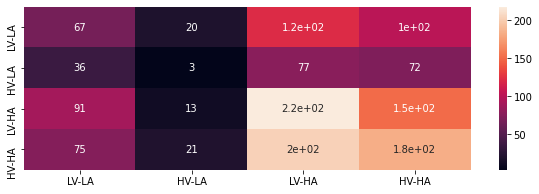

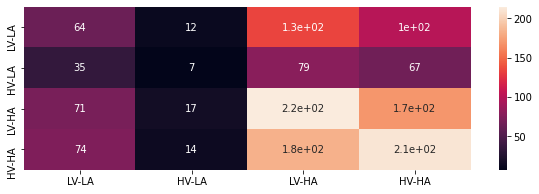

In [73]:
# Import required packages
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Plot confusion matrix participant-wise
array = cm_raw_participantwise
df_cm = pd.DataFrame(array, index = ["LV-LA", "HV-LA", "LV-HA", "HV-HA"],
                  columns = ["LV-LA", "HV-LA", "LV-HA", "HV-HA"])
plt.figure(figsize = (10,3))
sn.heatmap(df_cm, annot=True)

# Plot confusion matrix clip-wise
array = cm_raw_clipwise
df_cm = pd.DataFrame(array, index = ["LV-LA", "HV-LA", "LV-HA", "HV-HA"],
                  columns = ["LV-LA", "HV-LA", "LV-HA", "HV-HA"])
plt.figure(figsize = (10,3))
sn.heatmap(df_cm, annot=True)


###C) Selection of 10 preferred features

In [74]:
# Function to evaluate classification from 10 random features

def evaluate_ten_features():

  # Generate 10 random features
  range_features = range(0,186)
  x = random.sample(range_features,10)

  feat_1 = feat = features[:,x[0]].reshape((1455,1))
  feat_2 = feat = features[:,x[1]].reshape((1455,1))
  feat_3 = feat = features[:,x[2]].reshape((1455,1))
  feat_4 = feat = features[:,x[3]].reshape((1455,1))
  feat_5 = feat = features[:,x[4]].reshape((1455,1))
  feat_6 = feat = features[:,x[5]].reshape((1455,1))
  feat_7 = feat = features[:,x[6]].reshape((1455,1))
  feat_8 = feat = features[:,x[7]].reshape((1455,1))
  feat_9 = feat = features[:,x[8]].reshape((1455,1))
  feat_10 = feat = features[:,x[9]].reshape((1455,1))

  selected_ten_features = np.concatenate((feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10), axis=1)

  # Participant-wise grouping
  participant_clips_idx = sum_previous_ones(participant_clips)
  features_participantwise_list = np.split(selected_ten_features, participant_clips_idx[:-1], axis=0)
  labels_participantwise_list = np.split(Arousal_Valence, participant_clips_idx[:-1], axis=0)
  features_participantwise = np.array(features_participantwise_list)
  labels_participantwise = np.array(labels_participantwise_list)

  # Clip-wise grouping
  features_clipwise_list = []
  labels_clipwise_list = []

  for i in range(max(clips_indexing)):

    features_clipwise_list.append([])
    labels_clipwise_list.append([])
  features_list = selected_ten_features.tolist()
  labels_list = Arousal_Valence.tolist()

  for i in range(len(clips_indexing)):

    idx = clips_indexing[i] - 1
    # features_clipwise_list[idx] += features_list[i]
    features_clipwise_list[idx].append(features_list[i])
    labels_clipwise_list[idx].append(labels_list[i])

  for i in range(len(features_clipwise_list)):

    features_clipwise_list[i] = np.array(features_clipwise_list[i])
    labels_clipwise_list[i] = np.array(labels_clipwise_list[i])

  features_clipwise = np.array(features_clipwise_list)
  labels_clipwise = np.array(labels_clipwise_list)

  # Leave one PARTICIPANT out classification
  X = features_participantwise
  y = labels_participantwise

  predicted_labels = []
  true_labels = []

  loo = LeaveOneOut()
  j = 1
  for train_idx, test_idx in loo.split(X):

    #print('Run number ' + str(j))
    j+=1
    X_test = X[test_idx]
    X_train = X[train_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Impute missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(np.concatenate(X_train))
    X_train_imputed = imp.transform(np.concatenate(X_train))
    X_test_imputed = imp.transform(np.concatenate(X_test))

    # Classifier
    clf = RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=20, class_weight = 'balanced_subsample', max_features = 'sqrt', random_state=0)
    clf.fit(X_train_imputed, np.concatenate(y_train))
    #print(clf.predict(X_test_imputed))
    predicted_labels.append(clf.predict(X_test_imputed))
    #print(np.concatenate(y_test).tolist())
    true_labels.append(np.concatenate(y_test).tolist())
      
  predicted_labels_array = np.concatenate(predicted_labels[:])
  true_labels_array = np.concatenate(true_labels[:])

  # Calculate metrics - Participant-wise
  accuracy_part = accuracy_score(true_labels_array, predicted_labels_array)
  cm_part = confusion_matrix(true_labels_array, predicted_labels_array)
  cm_part = cm_part.astype('float') / cm_part.sum(axis=1)[:, np.newaxis]
  cm_diagonal_part = cm_part.diagonal()
  prec_part, recall_part, f1_part, support_part = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

  # Leave one CLIP out classification
  X = features_clipwise
  y = labels_clipwise

  predicted_labels = []
  true_labels = []

  loo = LeaveOneOut()
  j = 1
  for train_idx, test_idx in loo.split(X):

    #print('Run number ' + str(j))
    j+=1
    X_test = X[test_idx]
    X_train = X[train_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Impute missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(np.concatenate(X_train))
    X_train_imputed = imp.transform(np.concatenate(X_train))
    X_test_imputed = imp.transform(np.concatenate(X_test))
    
    # Classifier
    clf = RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=20, class_weight = 'balanced_subsample', max_features = 'sqrt', random_state=0)
    clf.fit(X_train_imputed, np.concatenate(y_train))
    #print(clf.predict(X_test_imputed))
    predicted_labels.append(clf.predict(X_test_imputed))
    #print(np.concatenate(y_test).tolist())
    true_labels.append(np.concatenate(y_test).tolist())
      
  predicted_labels_array = np.concatenate(predicted_labels[:])
  true_labels_array = np.concatenate(true_labels[:])

  # Calculate metrics - Clip-wise
  accuracy_clip = accuracy_score(true_labels_array, predicted_labels_array)
  cm_clip = confusion_matrix(true_labels_array, predicted_labels_array)
  cm_clip = cm_clip.astype('float') / cm_clip.sum(axis=1)[:, np.newaxis]
  cm_diagonal_clip = cm_clip.diagonal()
  prec_clip, recall_clip, f1_clip, support_clip = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

  # Write results to a text file
  outF = open("./drive/MyDrive/Colab Notebooks/data2/Ten_feat_results.txt", "a")
  outF.write("Features: {},{},{},{},{},{},{},{},{},{}\n".format(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9]))
  outF.write("Part -> Acc: {}, Acc_cl: {}, Prec: {}, Rec: {}, F1: {}\n".format(accuracy_part, cm_diagonal_part, prec_part, recall_part, f1_part))
  outF.write("Clip -> Acc: {}, Acc_cl: {}, Prec: {}, Rec: {}, F1: {}".format(accuracy_clip, cm_diagonal_clip, prec_clip, recall_clip, f1_clip))
  outF.write("\n\n")
  outF.close()

In [75]:
# Run function for evaluation of 10 random features for a specified number of iterations
Number_iterations = 3

# Import required packages
import random
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Run function
for i in range(Number_iterations):
  evaluate_ten_features()

In [76]:
# Function to evaluate classification for features of a specific modality

def evaluate_one_feature_class(idx_in, idx_out):

  # Pick the features of interest
  selected_features = features[:, idx_in : idx_out]

  # Participant-wise grouping
  participant_clips_idx = sum_previous_ones(participant_clips)
  features_participantwise_list = np.split(selected_features, participant_clips_idx[:-1], axis=0)
  labels_participantwise_list = np.split(Arousal_Valence, participant_clips_idx[:-1], axis=0)
  features_participantwise = np.array(features_participantwise_list)
  labels_participantwise = np.array(labels_participantwise_list)

  # Clip-wise grouping
  features_clipwise_list = []
  labels_clipwise_list = []

  for i in range(max(clips_indexing)):

    features_clipwise_list.append([])
    labels_clipwise_list.append([])
  features_list = selected_features.tolist()
  labels_list = Arousal_Valence.tolist()

  for i in range(len(clips_indexing)):

    idx = clips_indexing[i] - 1
    # features_clipwise_list[idx] += features_list[i]
    features_clipwise_list[idx].append(features_list[i])
    labels_clipwise_list[idx].append(labels_list[i])

  for i in range(len(features_clipwise_list)):

    features_clipwise_list[i] = np.array(features_clipwise_list[i])
    labels_clipwise_list[i] = np.array(labels_clipwise_list[i])
  features_clipwise = np.array(features_clipwise_list)
  labels_clipwise = np.array(labels_clipwise_list)

  # Leave one PARTICIPANT out classification
  X = features_participantwise
  y = labels_participantwise

  predicted_labels = []
  true_labels = []

  loo = LeaveOneOut()
  j = 1
  for train_idx, test_idx in loo.split(X):

    #print('Run number ' + str(j))
    j+=1
    X_test = X[test_idx]
    X_train = X[train_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Impute missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(np.concatenate(X_train))
    X_train_imputed = imp.transform(np.concatenate(X_train))
    X_test_imputed = imp.transform(np.concatenate(X_test))

    # Classifier
    clf = RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=20, class_weight = 'balanced_subsample', max_features = 'sqrt', random_state=0)
    clf.fit(X_train_imputed, np.concatenate(y_train))

    #print(clf.predict(X_test_imputed))
    predicted_labels.append(clf.predict(X_test_imputed))
    #print(np.concatenate(y_test).tolist())
    true_labels.append(np.concatenate(y_test).tolist())
      
  predicted_labels_array = np.concatenate(predicted_labels[:])
  true_labels_array = np.concatenate(true_labels[:])

  # Calculate metrics - Participant-wise
  accuracy_part = accuracy_score(true_labels_array, predicted_labels_array)
  cm_part = confusion_matrix(true_labels_array, predicted_labels_array)
  cm_part = cm_part.astype('float') / cm_part.sum(axis=1)[:, np.newaxis]
  cm_diagonal_part = cm_part.diagonal()
  prec_part, recall_part, f1_part, support_part = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

  # Leave one CLIP out classification
  X = features_clipwise
  y = labels_clipwise

  predicted_labels = []
  true_labels = []

  loo = LeaveOneOut()
  j = 1
  for train_idx, test_idx in loo.split(X):

    #print('Run number ' + str(j))
    j+=1
    X_test = X[test_idx]
    X_train = X[train_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Impute missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(np.concatenate(X_train))
    X_train_imputed = imp.transform(np.concatenate(X_train))
    X_test_imputed = imp.transform(np.concatenate(X_test))
    
    # Classifier
    clf = RandomForestClassifier(max_depth=100, min_samples_split=2, n_estimators=20, class_weight = 'balanced_subsample', max_features = 'sqrt', random_state=0)
    clf.fit(X_train_imputed, np.concatenate(y_train))
    #print(clf.predict(X_test_imputed))
    predicted_labels.append(clf.predict(X_test_imputed))
    #print(np.concatenate(y_test).tolist())
    true_labels.append(np.concatenate(y_test).tolist())
      
  predicted_labels_array = np.concatenate(predicted_labels[:])
  true_labels_array = np.concatenate(true_labels[:])

  # Calculate metrics - Clip-wise
  accuracy_clip = accuracy_score(true_labels_array, predicted_labels_array)
  cm_clip = confusion_matrix(true_labels_array, predicted_labels_array)
  cm_clip = cm_clip.astype('float') / cm_clip.sum(axis=1)[:, np.newaxis]
  cm_diagonal_clip = cm_clip.diagonal()
  prec_clip, recall_clip, f1_clip, support_clip = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

  # Write results to a text file
  outF = open("./drive/MyDrive/Colab Notebooks/data2/Features_class_comparison.txt", "a")
  outF.write("Indexes: {},{}\n".format(idx_in, idx_out))
  outF.write("Part -> Acc: {}, Acc_cl: {}, Prec: {}, Rec: {}, F1: {}\n".format(accuracy_part, cm_diagonal_part, prec_part, recall_part, f1_part))
  outF.write("Clip -> Acc: {}, Acc_cl: {}, Prec: {}, Rec: {}, F1: {}".format(accuracy_clip, cm_diagonal_clip, prec_clip, recall_clip, f1_clip))
  outF.write("\n\n")
  outF.close()

In [77]:
# Get data isolating features from each modality each time

# Import required packages
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# ECG
idx_in, idx_out = 0, 55
evaluate_one_feature_class(idx_in, idx_out)

# EDA
idx_in, idx_out = 56, 87
evaluate_one_feature_class(idx_in, idx_out)

# EEG
idx_in, idx_out = 88, 119
evaluate_one_feature_class(idx_in, idx_out)

# EMO
idx_in, idx_out = 119, 191
evaluate_one_feature_class(idx_in, idx_out)

###D) Implementation of the ZeroR algorithm and comparison with the Random Forest Classifier

In [78]:
# Leave one CLIP out classification - ZeroR Classification

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.dummy import DummyClassifier

X = features_clipwise
y = labels_clipwise

predicted_labels = []
true_labels = []

loo = LeaveOneOut()
j = 1
for train_idx, test_idx in loo.split(X):

  print('Run number ' + str(j))
  j+=1
  X_test = X[test_idx]
  X_train = X[train_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # Impute missing data
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(np.concatenate(X_train))
  X_train_imputed = imp.transform(np.concatenate(X_train))
  X_test_imputed = imp.transform(np.concatenate(X_test))

  # Classifier
  zero_rule_classifier = DummyClassifier(strategy="most_frequent")
  zero_rule_classifier.fit(X_train_imputed, np.concatenate(y_train))

  print(zero_rule_classifier.predict(X_test_imputed))
  print(np.concatenate(y_test).tolist())
  #print(zero_rule_classifier.predict(X_test_imputed))
  
  predicted_labels.append(zero_rule_classifier.predict(X_test_imputed))
  #print(np.concatenate(y_test).tolist())
  true_labels.append(np.concatenate(y_test).tolist())
      
predicted_labels_array = np.concatenate(predicted_labels[:])
true_labels_array = np.concatenate(true_labels[:])

Run number 1
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3]
[4, 4, 4, 1, 1, 4, 4, 4, 4, 3, 4, 2, 2, 4, 1, 1, 4, 4, 4, 4, 2, 4, 1, 2, 4, 4, 4, 1, 4, 2, 4, 4, 1, 4, 1, 4, 1, 4, 1, 4]
Run number 2
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]
[1, 4, 4, 2, 1, 4, 1, 4, 4, 1, 4, 4, 2, 4, 3, 2, 3, 2, 4, 4, 2, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2]
Run number 3
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]
[4, 1, 4, 2, 4, 4, 4, 4, 4, 1, 1, 2, 2, 1, 2, 4, 2, 3, 4, 1, 1, 3, 4, 4, 1, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1]
Run number 4
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3]
[4, 4, 4, 3, 1, 3, 4, 4, 1, 4, 4, 3, 4, 2, 4, 3, 4, 4, 2, 4, 4, 3, 2, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 4, 4, 4, 1, 3, 4]
Run number 5
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3]
[4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 

In [79]:
# CALCULATE METRICS OF OVERALL ACCURACY, ACCURACY PER CLASS (CONFUSION MATRIX), PRECISION PER CLASS, RECALL PER CLASS, F1-SCORE PER CLASS - Clip-wise

# Import required functions
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Calculate metrics 
accuracy = accuracy_score(true_labels_array, predicted_labels_array)
cm_raw = confusion_matrix(true_labels_array, predicted_labels_array) # Combined Confusion Matrix
cm_raw_clipwise = cm_raw
cm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
cm_diagonal = cm.diagonal()
prec, recall, f1, support = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

# Print metrics
print("Overall accuracy: {}".format(accuracy))
print("Accuracy of each class {}".format(cm_diagonal))
print("Precision of each class {}".format(prec))
print("Recall of each class {}".format(recall))
print("F1-score of each class {}".format(f1))
print("Number of occurences of each class {}".format(support))
print("The combined confusion matrix:")
print(cm_raw)

Overall accuracy: 0.06597938144329897
Accuracy of each class [0.         0.         0.07399577 0.126294  ]
Precision of each class [0.         0.         0.04854369 0.08310627]
Recall of each class [0.         0.         0.07399577 0.126294  ]
F1-score of each class [0.         0.         0.05862647 0.10024651]
Number of occurences of each class [311 188 473 483]
The combined confusion matrix:
[[  0   0  99 212]
 [  0   0 165  23]
 [  0   0  35 438]
 [  0   0 422  61]]


In [80]:
# Leave one PARTICIPANT out classification - ZeroR Classification

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

X = features_participantwise
y = labels_participantwise

predicted_labels = []
true_labels = []

loo = LeaveOneOut()
j = 1
for train_idx, test_idx in loo.split(X):

  print('Run number ' + str(j))
  j+=1
  X_test = X[test_idx]
  X_train = X[train_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  # Impute missing data
  imp = SimpleImputer(missing_values=np.nan, strategy='mean')
  imp.fit(np.concatenate(X_train))
  X_train_imputed = imp.transform(np.concatenate(X_train))
  X_test_imputed = imp.transform(np.concatenate(X_test))

  # Classifier
  zero_rule_classifier = DummyClassifier(strategy="most_frequent")
  zero_rule_classifier.fit(X_train_imputed, np.concatenate(y_train))

  print(zero_rule_classifier.predict(X_test_imputed))
  print(np.concatenate(y_test).tolist())
  #print(zero_rule_classifier.predict(X_test_imputed))
  
  predicted_labels.append(zero_rule_classifier.predict(X_test_imputed))
  #print(np.concatenate(y_test).tolist())
  true_labels.append(np.concatenate(y_test).tolist())
      
predicted_labels_array = np.concatenate(predicted_labels[:])
true_labels_array = np.concatenate(true_labels[:])

Run number 1
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[4, 1, 4, 4, 4, 4, 4, 2, 4, 1, 3, 4, 1, 4, 1, 4, 1, 1, 3, 1, 1, 1, 3, 3, 3, 4, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3]
Run number 2
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3]
Run number 3
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 2, 2, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3]
Run number 4
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[1, 2, 2, 3, 4, 2, 1, 4, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 3, 3, 1, 3, 2, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3]
Run number 5
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
[1, 1, 4, 1, 4, 1, 4, 4, 4, 2, 4, 4, 4, 1, 2, 4, 4, 2, 1, 4, 1, 1, 1, 2, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Run number 6
[4 4 4 

In [81]:
# CALCULATE METRICS OF OVERALL ACCURACY, ACCURACY PER CLASS (CONFUSION MATRIX), PRECISION PER CLASS, RECALL PER CLASS, F1-SCORE PER CLASS - participant-wise

# Import required functions
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(true_labels_array, predicted_labels_array)
cm_raw = confusion_matrix(true_labels_array, predicted_labels_array) # Combined Confusion Matrix
cm_raw_participantwise = cm_raw
cm = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
cm_diagonal = cm.diagonal()
prec, recall, f1, support = precision_recall_fscore_support(true_labels_array, predicted_labels_array)

# Print metrics
print("Overall accuracy: {}".format(accuracy))
print("Accuracy of each class {}".format(cm_diagonal))
print("Precision of each class {}".format(prec))
print("Recall of each class {}".format(recall))
print("F1-score of each class {}".format(f1))
print("Number of occurences of each class {}".format(support))
print("The combined confusion matrix:")
print(cm_raw)

Overall accuracy: 0.30721649484536084
Accuracy of each class [0.         0.         0.02325581 0.90269151]
Precision of each class [0.         0.         0.15277778 0.31525669]
Recall of each class [0.         0.         0.02325581 0.90269151]
F1-score of each class [0.         0.         0.04036697 0.46730975]
Number of occurences of each class [311 188 473 483]
The combined confusion matrix:
[[  0   0   9 302]
 [  0   0   5 183]
 [  0   0  11 462]
 [  0   0  47 436]]


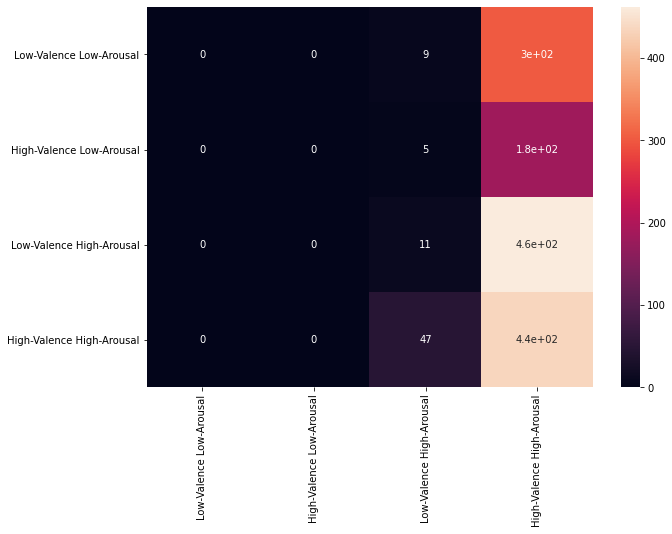

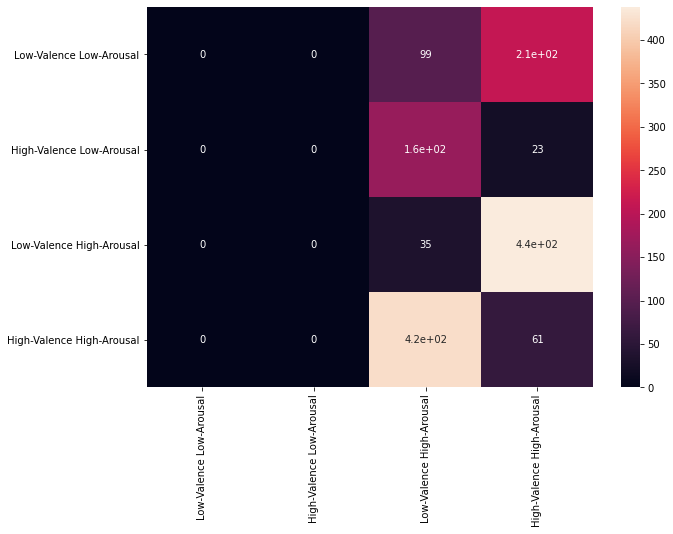

In [82]:
# Import required packages
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# Plot confusion matrix participant-wise
array = cm_raw_participantwise
df_cm = pd.DataFrame(array, index = ["Low-Valence Low-Arousal", "High-Valence Low-Arousal", "Low-Valence High-Arousal", "High-Valence High-Arousal"],
                  columns = ["Low-Valence Low-Arousal", "High-Valence Low-Arousal", "Low-Valence High-Arousal", "High-Valence High-Arousal"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Plot confusion matrix clip-wise
array = cm_raw_clipwise
df_cm = pd.DataFrame(array, index = ["Low-Valence Low-Arousal", "High-Valence Low-Arousal", "Low-Valence High-Arousal", "High-Valence High-Arousal"],
                  columns = ["Low-Valence Low-Arousal", "High-Valence Low-Arousal", "Low-Valence High-Arousal", "High-Valence High-Arousal"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)